# Monetary Policy
This notebook looks at a monetary policy shocks when there is a government. Here, we replicate [link](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%202%20Monetary%20Policy.ipynb)

In [1]:
#from ConsIndShockModel import IndShockConsumerType
from ConsIndShockModel_HANK import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import numpy as np
#import numba
import time

from scipy import optimize

# Case 1: Monetary Policy only

In [2]:
#Steady State values
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T


r_ss = 1.01 - 1
G_ss = 0
B_ss = 0 # this is lower than the tutorial by Straub et al. because need Higher MPC
A_ss = B_ss
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

T_ss: 0.0
Z_ss: 1.0
C_ss: 1.0


In [3]:
#------------------------------------------------------------------------------------------------------
Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1+r_ss,                    # Interest factor on assets
    "DiscFac": 0.96,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,    
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 1500,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 300,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : -0.1, #-0.01,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type 
    
    # Transition Matrix simulation parameters
    "mCount": 600,
    "mMax": 1000,
    "mMin": 0.0001,
    "mFac": 3,
}
T = 300 # Dimention of TxT Jacobian matrix

In [4]:
# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

Dict['TranShkMean_Func'] = [function]

# Get GE Steady stead values (TBD)

In [5]:
### Target only Steady State Asset
def ss_func(beta):
    Agent_func = IndShockConsumerType(**Dict, verbose = False)
    Agent_func.DiscFac = beta
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):
    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [6]:
Dict['DiscFac'] = DiscFac
Agent = IndShockConsumerType(**Dict, verbose = False)

In [7]:
DiscFac

0.8847823966299798

In [8]:
start = time.time()
Agent.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

Seconds to compute steady state 0.8582949638366699


In [9]:
start = time.time()

CJACR, AJACR = Agent.calc_jacobian('Rfree',T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 8.37693190574646


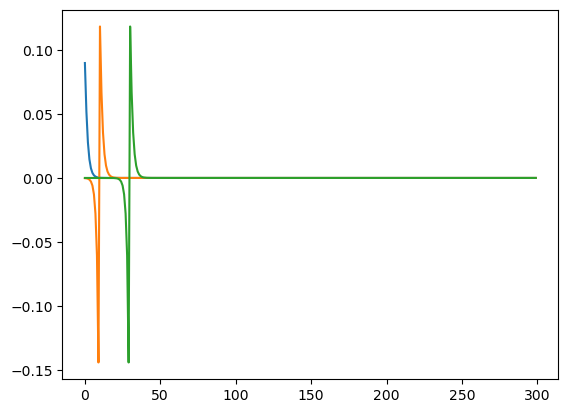

In [10]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[10])
plt.plot(CJACR.T[30])
plt.show()

In [11]:
@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

@sj.simple
def mkt_clearing_simple(A, Y, C):
    asset_mkt = A
    goods_mkt = C - Y
    return asset_mkt, goods_mkt

In [12]:
# HARK_SteadyState_Dict = SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "A": A_ss, "r_ante": r_ss})
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'r' : CJACR} ,'A' : {'r' : AJACR} } ) #r_ante

In [13]:
HARK_SteadyState_Dict = SteadyStateDict({"Y": Y_ss, "r_ante": r_ss, "r": r_ss, "C": C_ss, "A": A_ss, "asset_mkt":0.0})

In [14]:
HARK_SteadyState_Dict

<SteadyStateDict: ['Y', 'r_ante', 'r', 'C', 'A', 'asset_mkt']>

In [15]:
HARK_Jacobian_Dict['C']

{'r': array([[ 8.96958916e-02, -1.97998173e-01, -8.48598364e-02, ...,
         -9.09300815e-21, -9.09300612e-21, -9.09300457e-21],
        [ 5.18162739e-02,  8.96958916e-02, -1.57295965e-01, ...,
         -8.49610368e-21, -8.49610072e-21, -8.49609905e-21],
        [ 2.77398833e-02,  5.18162739e-02,  1.11192424e-01, ...,
         -7.94269540e-21, -7.94269242e-21, -7.94268979e-21],
        ...,
        [-2.66453526e-10, -6.63895500e-14, -8.53403195e-14, ...,
          1.18224139e-01, -1.44026414e-01, -6.04575971e-02],
        [-2.66453526e-10, -6.63895500e-14, -8.53403195e-14, ...,
          6.67000582e-02,  1.18224139e-01, -1.44026414e-01],
        [-2.66453526e-10, -6.63895500e-14, -8.53403195e-14, ...,
          3.54762911e-02,  6.67000582e-02,  1.18224139e-01]])}

In [16]:
HARK_HANK = create_model([HARK_Jacobian_Dict, ex_post_rate, mkt_clearing_simple], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['r_ante']

In [17]:
# Find the linear impulse responses to an "r" shock
dr = -0.01 * 0.7 ** np.arange(T)
shocks = {'r_ante': dr}

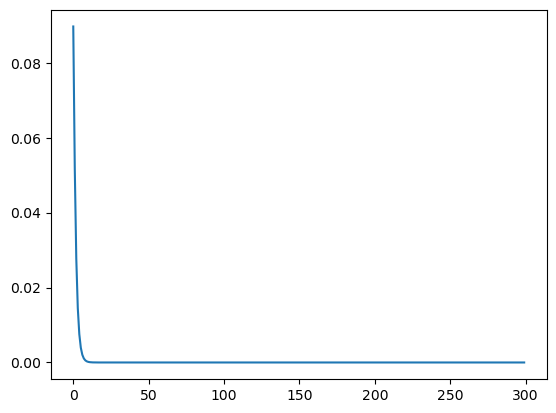

In [18]:
plt.plot(CJACR.T[0])
plt.show()

In [19]:
J_ex_post_rate = ex_post_rate.jacobian(HARK_SteadyState_Dict, inputs=['r_ante'])

In [20]:
J_ex_post_rate['r']

{'r_ante': SimpleSparse({(-1, 0): 1.000})}

In [21]:
irf = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, ['Y'], ['asset_mkt'], shocks) #{'r_ante': dr})
tutil.figure_1(irf, HARK_SteadyState_Dict, dr)

LinAlgError: Singular matrix

# Case 2: With Fiscal Policy

In [ ]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B
    Z = Y - T
    
    deficit = G - T
    
    return T, Z, deficit

In [ ]:
r_ss = 1.03 - 1
G_ss = 0
B_ss = 0 # this is lower than the tutorial by Straub et al. because need Higher MPC
A_ss = B_ss
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

## Steady State GE

In [ ]:
Agent_Case2 = IndShockConsumerType(**Dict, verbose = False)

In [ ]:
start = time.time()
Agent_Case2.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

In [ ]:
start = time.time()

CJACR_Case2, AJACR_Case2 = Agent_Case2.calc_jacobian('Rfree',T)

print('Seconds to calculate Jacobian', time.time() - start)

In [ ]:
HARK_SteadyState_Dict_Case2 = SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss,  "r_ante": r_ss })
HARK_Jacobian_Dict_Case2 = JacobianDict( { 'C' : {'r_ante' : CJACR_Case2} ,'A' : {'r_ante' : AJACR_Case2} } )

In [ ]:
HARK_HANK_Case2 = create_model([HARK_Jacobian_Dict, fiscal, ex_post_rate, mkt_clearing_simple], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['r_ante']

In [ ]:
irf_Case2 = HARK_HANK_Case2.solve_impulse_linear(HARK_SteadyState_Dict_Case2, ['Y'], ['asset_mkt'], shocks) #{'r_ante': dr})
tutil.figure_1(irf_Case2, HARK_SteadyState_Dict_Case2, dr)